# Prétraitement et Nettoyage des Données

Ce notebook prépare les données pour la modélisation en effectuant :
- Nettoyage du texte avec NLTK
- Tokenisation, lemmatisation et suppression des stopwords
- Suppression des doublons
- Création des datasets train/validation/test

In [2]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLTK pour le traitement du texte
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
sns.set_style('whitegrid')

In [3]:
# Téléchargement des ressources NLTK nécessaires
for resource in ['stopwords', 'wordnet', 'omw-1.4']:
    try:
        nltk.data.find(f'corpora/{resource}')
        print(f"✓ {resource} déjà téléchargé")
    except LookupError:
        print(f"Téléchargement de {resource}...")
        nltk.download(resource, quiet=True)
        print(f"✓ {resource} téléchargé")

✓ stopwords déjà téléchargé
Téléchargement de wordnet...
✓ wordnet téléchargé
Téléchargement de omw-1.4...
✓ omw-1.4 téléchargé


## 1. Chargement des Données

In [4]:
# Chargement du dataset
column_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df = pd.read_csv('../data/training.1600000.processed.noemoticon.csv',
                 encoding='latin-1',
                 names=column_names,
                 header=None)

print(f"Dataset initial : {df.shape}")

# Conversion du sentiment en binaire
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

Dataset initial : (1600000, 6)


In [5]:
# Affichage d'exemples avant nettoyage
print("Exemples de tweets AVANT nettoyage :")
print("="*80)
for i, text in enumerate(df['text'].sample(5, random_state=42).values, 1):
    print(f"{i}. {text}\n")

Exemples de tweets AVANT nettoyage :
1. @chrishasboobs AHHH I HOPE YOUR OK!!! 

2. @misstoriblack cool , i have no tweet apps  for my razr 2

3. @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u

4. School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(

5. upper airways problem 



## 2. Détection et Suppression des Doublons

In [6]:
# Vérification des doublons
print("Analyse des doublons :")
print(f"Doublons complets : {df.duplicated().sum():,}")
print(f"Doublons sur le texte : {df.duplicated(subset=['text']).sum():,}")
print(f"Doublons sur texte + sentiment : {df.duplicated(subset=['text', 'sentiment']).sum():,}")

Analyse des doublons :
Doublons complets : 0
Doublons sur le texte : 18,534
Doublons sur texte + sentiment : 16,309


In [7]:
# Suppression des doublons sur le texte
df_original_size = len(df)
df = df.drop_duplicates(subset=['text'], keep='first')
df_after_dedup = len(df)

print(f"Tweets supprimés : {df_original_size - df_after_dedup:,}")
print(f"Pourcentage supprimé : {(df_original_size - df_after_dedup)/df_original_size*100:.2f}%")
print(f"Nouvelle taille du dataset : {len(df):,}")

Tweets supprimés : 18,534
Pourcentage supprimé : 1.16%
Nouvelle taille du dataset : 1,581,466


In [8]:
# Vérification de l'équilibre après suppression des doublons
print("\nDistribution des sentiments après suppression des doublons :")
print(df['sentiment'].value_counts())
print("\nProportions :")
print(df['sentiment'].value_counts(normalize=True))


Distribution des sentiments après suppression des doublons :
sentiment
1    791281
0    790185
Name: count, dtype: int64

Proportions :
sentiment
1    0.500347
0    0.499653
Name: proportion, dtype: float64


## 3. Initialisation des Outils NLTK

In [9]:
# Initialisation des outils NLP
pattern = r"[A-Za-z']+"  # Motif pour capturer les mots (avec apostrophes pour les contractions)
tokenizer = RegexpTokenizer(pattern)
english_stopwords = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

print(f"Tokenizer initialisé avec le pattern : {pattern}")
print(f"Nombre de stopwords anglais : {len(english_stopwords)}")
print(f"Exemples de stopwords : {list(english_stopwords)[:10]}")

Tokenizer initialisé avec le pattern : [A-Za-z']+
Nombre de stopwords anglais : 198
Exemples de stopwords : ['herself', 'has', "it'll", 'an', 's', 'their', 'they', 'those', 'now', "they'd"]


## 4. Fonctions de Nettoyage avec NLTK

In [10]:
def tokenize_text(text):
    """
    Tokenise un texte en mots individuels.
    
    Args:
        text (str): Texte à tokeniser
    
    Returns:
        list: Liste de tokens
    """
    if pd.isna(text) or not isinstance(text, str):
        return []
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens

def stem_text(tokens):
    """
    Applique le stemming sur une liste de tokens.
    
    Args:
        tokens (list): Liste de tokens
    
    Returns:
        list: Liste de tokens stemmés
    """
    return [stemmer.stem(token) for token in tokens]

def lemmatize_text(tokens):
    """
    Applique la lemmatisation sur une liste de tokens.
    
    Args:
        tokens (list): Liste de tokens
    
    Returns:
        list: Liste de tokens lemmatisés
    """
    return [lemmatizer.lemmatize(token) for token in tokens]

def clean_tweet(text, use_stemming=False, remove_stopwords=True):
    """
    Fonction complète de nettoyage de texte pour tweets.
    
    Étapes :
    1. Suppression des URLs, mentions, hashtags
    2. Conversion en minuscules
    3. Tokenisation avec NLTK
    4. Suppression des stopwords (optionnel)
    5. Filtrage (longueur > 2 caractères)
    6. Lemmatisation ou stemming
    
    Args:
        text (str): Texte à nettoyer
        use_stemming (bool): Si True, utilise stemming, sinon lemmatisation
        remove_stopwords (bool): Si True, supprime les stopwords
    
    Returns:
        str: Texte nettoyé
    """
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Suppression des mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Suppression des hashtags (enlève le # mais garde le mot)
    text = re.sub(r'#', '', text)
    
    # Suppression des RT (retweet)
    text = re.sub(r'\brt\b', '', text)
    
    # Suppression des caractères non alphabétiques (sauf espaces)
    text = re.sub(r"[^a-z\s']+", " ", text)
    
    # Tokenisation
    tokens = tokenizer.tokenize(text)
    
    # Suppression des stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in english_stopwords]
    
    # Filtrage : longueur > 2 et contient au moins une lettre
    tokens = [t for t in tokens if len(t) > 2 and any(c.isalpha() for c in t)]
    
    # Stemming ou lemmatisation
    if use_stemming:
        tokens = stem_text(tokens)
    else:
        tokens = lemmatize_text(tokens)
    
    return " ".join(tokens)

## 5. Test des Fonctions de Nettoyage

In [11]:
# Test sur des exemples
test_tweets = [
    "@user I love this movie! http://example.com #awesome",
    "I can't believe this happened... Really disappointed :(",
    "RT @someone: Great news!!! Visit www.example.com for more info",
    "This is soooo bad 123 times worse than expected!!!",
    "@friend Won't be able to make it. Sorry! #sad"
]

print("="*80)
print("TEST DES FONCTIONS DE NETTOYAGE")
print("="*80)

for i, tweet in enumerate(test_tweets, 1):
    print(f"\n{i}. Tweet original :")
    print(f"   {tweet}")
    
    tokens = tokenize_text(tweet)
    print(f"   Tokens : {tokens[:10]}")
    
    print(f"   Lemmatisé (avec stopwords) : {clean_tweet(tweet, use_stemming=False, remove_stopwords=False)}")
    print(f"   Lemmatisé (sans stopwords) : {clean_tweet(tweet, use_stemming=False, remove_stopwords=True)}")
    print(f"   Stemmé (sans stopwords) : {clean_tweet(tweet, use_stemming=True, remove_stopwords=True)}")

TEST DES FONCTIONS DE NETTOYAGE

1. Tweet original :
   @user I love this movie! http://example.com #awesome
   Tokens : ['user', 'i', 'love', 'this', 'movie', 'http', 'example', 'com', 'awesome']
   Lemmatisé (avec stopwords) : love this movie awesome
   Lemmatisé (sans stopwords) : love movie awesome
   Stemmé (sans stopwords) : love movi awesom

2. Tweet original :
   I can't believe this happened... Really disappointed :(
   Tokens : ['i', "can't", 'believe', 'this', 'happened', 'really', 'disappointed']
   Lemmatisé (avec stopwords) : can't believe this happened really disappointed
   Lemmatisé (sans stopwords) : can't believe happened really disappointed
   Stemmé (sans stopwords) : can't believ happen realli disappoint

3. Tweet original :
   RT @someone: Great news!!! Visit www.example.com for more info
   Tokens : ['rt', 'someone', 'great', 'news', 'visit', 'www', 'example', 'com', 'for', 'more']
   Lemmatisé (avec stopwords) : great news visit for more info
   Lemmatisé (sans

## 6. Application du Nettoyage sur le Dataset

In [12]:
# Application du nettoyage sur le dataset complet
# On va créer 2 versions : avec lemmatisation et avec stemming
print("Application du nettoyage sur le dataset complet...")
print("Cela peut prendre plusieurs minutes (1.6M tweets)...")
print()

# Version avec lemmatisation (recommandé pour l'analyse de sentiments)
print("1/2 - Lemmatisation en cours...")
df['text_lemmatized'] = df['text'].apply(lambda x: clean_tweet(x, use_stemming=False, remove_stopwords=True))
print("✓ Lemmatisation terminée")

# Version avec stemming (pour comparaison)
print("2/2 - Stemming en cours...")
df['text_stemmed'] = df['text'].apply(lambda x: clean_tweet(x, use_stemming=True, remove_stopwords=True))
print("✓ Stemming terminé")

print("\nNettoyage terminé !")

Application du nettoyage sur le dataset complet...
Cela peut prendre plusieurs minutes (1.6M tweets)...

1/2 - Lemmatisation en cours...
✓ Lemmatisation terminée
2/2 - Stemming en cours...
✓ Stemming terminé

Nettoyage terminé !


In [13]:
# On va utiliser la version lemmatisée par défaut
df['text_cleaned'] = df['text_lemmatized']

# Vérification des textes vides après nettoyage
empty_texts = df['text_cleaned'].str.strip() == ''
print(f"Nombre de textes vides après nettoyage : {empty_texts.sum():,}")

if empty_texts.sum() > 0:
    print(f"Suppression des textes vides...")
    df = df[~empty_texts].copy()
    print(f"Nouvelle taille du dataset : {len(df):,}")

Nombre de textes vides après nettoyage : 9,773
Suppression des textes vides...
Nouvelle taille du dataset : 1,571,693


## 7. Analyse de l'Impact du Nettoyage

In [14]:
# Statistiques sur la longueur après nettoyage
df['text_length_cleaned'] = df['text_cleaned'].str.len()
df['word_count_cleaned'] = df['text_cleaned'].str.split().str.len()

print("Statistiques AVANT et APRÈS nettoyage :")
print("\nLongueur du texte (caractères) :")
print(f"  Avant : {df['text'].str.len().mean():.1f} ± {df['text'].str.len().std():.1f}")
print(f"  Après : {df['text_length_cleaned'].mean():.1f} ± {df['text_length_cleaned'].std():.1f}")

print("\nNombre de mots :")
print(f"  Avant : {df['text'].str.split().str.len().mean():.1f} ± {df['text'].str.split().str.len().std():.1f}")
print(f"  Après : {df['word_count_cleaned'].mean():.1f} ± {df['word_count_cleaned'].std():.1f}")

Statistiques AVANT et APRÈS nettoyage :

Longueur du texte (caractères) :
  Avant : 74.8 ± 36.1
  Après : 40.8 ± 22.9

Nombre de mots :
  Avant : 13.3 ± 6.9
  Après : 6.7 ± 3.7


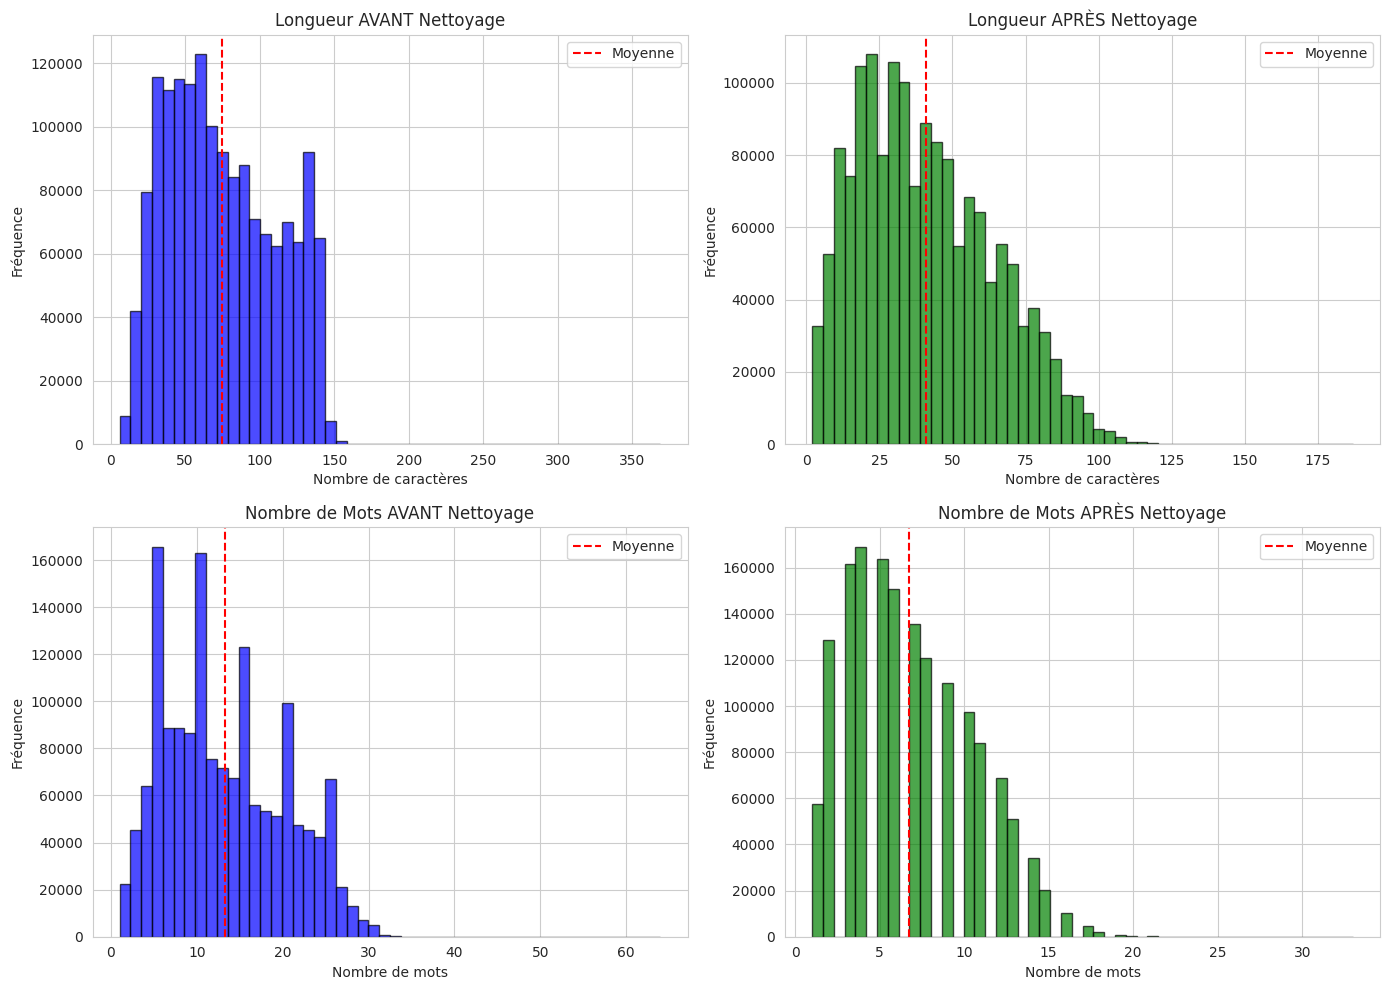

In [15]:
# Visualisation de l'impact du nettoyage
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Longueur avant
axes[0, 0].hist(df['text'].str.len(), bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_title('Longueur AVANT Nettoyage')
axes[0, 0].set_xlabel('Nombre de caractères')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].axvline(df['text'].str.len().mean(), color='red', linestyle='--', label='Moyenne')
axes[0, 0].legend()

# Longueur après
axes[0, 1].hist(df['text_length_cleaned'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Longueur APRÈS Nettoyage')
axes[0, 1].set_xlabel('Nombre de caractères')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].axvline(df['text_length_cleaned'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0, 1].legend()

# Mots avant
axes[1, 0].hist(df['text'].str.split().str.len(), bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_title('Nombre de Mots AVANT Nettoyage')
axes[1, 0].set_xlabel('Nombre de mots')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].axvline(df['text'].str.split().str.len().mean(), color='red', linestyle='--', label='Moyenne')
axes[1, 0].legend()

# Mots après
axes[1, 1].hist(df['word_count_cleaned'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('Nombre de Mots APRÈS Nettoyage')
axes[1, 1].set_xlabel('Nombre de mots')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].axvline(df['word_count_cleaned'].mean(), color='red', linestyle='--', label='Moyenne')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Comparaison d'exemples avant/après
print("EXEMPLES DE TWEETS AVANT/APRÈS NETTOYAGE :")
print("="*80)
sample_indices = df.sample(5, random_state=42).index

for idx in sample_indices:
    print(f"\nSentiment : {'POSITIF' if df.loc[idx, 'sentiment'] == 1 else 'NÉGATIF'}")
    print(f"AVANT : {df.loc[idx, 'text']}")
    print(f"APRÈS (lemmatisé) : {df.loc[idx, 'text_lemmatized']}")
    print(f"APRÈS (stemmé) : {df.loc[idx, 'text_stemmed']}")
    print("-"*80)

EXEMPLES DE TWEETS AVANT/APRÈS NETTOYAGE :

Sentiment : POSITIF
AVANT : @riskybusinessmb I LOVE YOU 
APRÈS (lemmatisé) : love
APRÈS (stemmé) : love
--------------------------------------------------------------------------------

Sentiment : NÉGATIF
AVANT : @cokies forgetting about someone is even worse than missing them.. that's my phobia 
APRÈS (lemmatisé) : forgetting someone even worse missing that's phobia
APRÈS (stemmé) : forget someon even wors miss that phobia
--------------------------------------------------------------------------------

Sentiment : NÉGATIF
AVANT : Terrible migraine...  long night/couldn't sleep.  Stop the pain! 
APRÈS (lemmatisé) : terrible migraine long night sleep stop pain
APRÈS (stemmé) : terribl migrain long night sleep stop pain
--------------------------------------------------------------------------------

Sentiment : NÉGATIF
AVANT : @pamslim I'm in Ann Arbor. Ironically, I'll be stuck in my cubicle unable to listen to the radio at 9:40am. 
APRÈS (

## 8. Filtrage des Tweets Trop Courts

In [17]:
# Analyse des tweets très courts
print("Distribution des longueurs (mots) :")
print(df['word_count_cleaned'].value_counts().sort_index().head(10))

Distribution des longueurs (mots) :
word_count_cleaned
1      57573
2     128583
3     161747
4     169037
5     163747
6     150831
7     135560
8     120969
9     110115
10     97323
Name: count, dtype: int64


In [18]:
# Filtrage des tweets avec moins de 3 mots
min_words = 3
short_tweets = df['word_count_cleaned'] < min_words

print(f"Tweets avec moins de {min_words} mots : {short_tweets.sum():,} ({short_tweets.mean()*100:.2f}%)")

df = df[~short_tweets].copy()
print(f"Nouvelle taille du dataset : {len(df):,}")

Tweets avec moins de 3 mots : 186,156 (11.84%)
Nouvelle taille du dataset : 1,385,537


In [19]:
# Vérification de l'équilibre après filtrage
print("\nDistribution des sentiments après filtrage :")
print(df['sentiment'].value_counts())
print("\nProportions :")
print(df['sentiment'].value_counts(normalize=True))


Distribution des sentiments après filtrage :
sentiment
0    701852
1    683685
Name: count, dtype: int64

Proportions :
sentiment
0    0.506556
1    0.493444
Name: proportion, dtype: float64


## 9. Création des Splits Train/Validation/Test

In [20]:
# Split stratifié : 70% train, 15% validation, 15% test

# On va créer 2 ensembles : avec lemmatisation et avec stemming
X_lemma = df['text_lemmatized']
X_stem = df['text_stemmed']
y = df['sentiment']

# Split train vs reste (70/30)
X_train_lemma, X_temp_lemma, y_train, y_temp = train_test_split(
    X_lemma, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_train_stem, X_temp_stem = train_test_split(
    X_stem,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Split validation vs test (50/50 du reste = 15/15)
X_val_lemma, X_test_lemma, y_val, y_test = train_test_split(
    X_temp_lemma, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

X_val_stem, X_test_stem = train_test_split(
    X_temp_stem,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Tailles des datasets :")
print(f"Train : {len(X_train_lemma):,} ({len(X_train_lemma)/len(df)*100:.1f}%)")
print(f"Validation : {len(X_val_lemma):,} ({len(X_val_lemma)/len(df)*100:.1f}%)")
print(f"Test : {len(X_test_lemma):,} ({len(X_test_lemma)/len(df)*100:.1f}%)")

Tailles des datasets :
Train : 969,875 (70.0%)
Validation : 207,831 (15.0%)
Test : 207,831 (15.0%)


In [21]:
# Vérification de l'équilibre dans chaque split
print("\nDistribution des sentiments dans chaque split :")
print("\nTrain :")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

print("\nValidation :")
print(y_val.value_counts())
print(y_val.value_counts(normalize=True))

print("\nTest :")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))


Distribution des sentiments dans chaque split :

Train :
sentiment
0    491296
1    478579
Name: count, dtype: int64
sentiment
0    0.506556
1    0.493444
Name: proportion, dtype: float64

Validation :
sentiment
0    105278
1    102553
Name: count, dtype: int64
sentiment
0    0.506556
1    0.493444
Name: proportion, dtype: float64

Test :
sentiment
0    105278
1    102553
Name: count, dtype: int64
sentiment
0    0.506556
1    0.493444
Name: proportion, dtype: float64


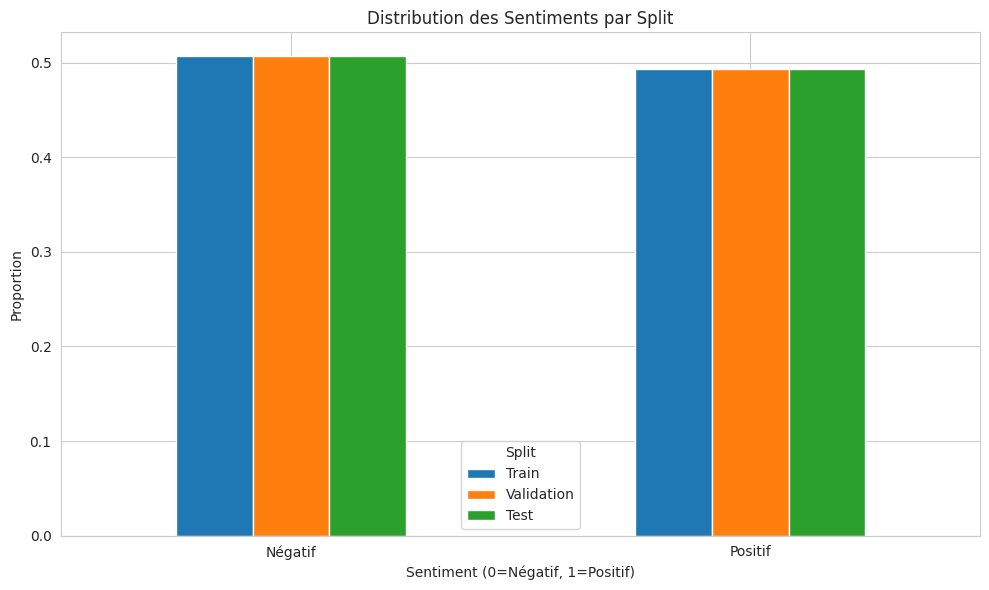

In [22]:
# Visualisation de la distribution
splits_data = pd.DataFrame({
    'Train': y_train.value_counts(normalize=True).sort_index(),
    'Validation': y_val.value_counts(normalize=True).sort_index(),
    'Test': y_test.value_counts(normalize=True).sort_index()
})

splits_data.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution des Sentiments par Split')
plt.xlabel('Sentiment (0=Négatif, 1=Positif)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Négatif', 'Positif'], rotation=0)
plt.legend(title='Split')
plt.tight_layout()
plt.show()

## 10. Création d'un Échantillon Réduit pour Tests Rapides

In [23]:
# Création d'un échantillon de 100k tweets pour tests rapides
sample_size = 100000

if len(X_train_lemma) > sample_size:
    X_train_lemma_sample, _, y_train_sample, _ = train_test_split(
        X_train_lemma, y_train,
        train_size=sample_size,
        random_state=42,
        stratify=y_train
    )
    
    X_train_stem_sample, _ = train_test_split(
        X_train_stem,
        train_size=sample_size,
        random_state=42,
        stratify=y_train
    )
    
    print(f"Échantillon réduit créé : {len(X_train_lemma_sample):,} tweets")
    print("Distribution :")
    print(y_train_sample.value_counts())
    print(y_train_sample.value_counts(normalize=True))
else:
    X_train_lemma_sample = X_train_lemma
    X_train_stem_sample = X_train_stem
    y_train_sample = y_train
    print("Dataset train déjà inférieur à 100k, pas d'échantillonnage nécessaire")

Échantillon réduit créé : 100,000 tweets
Distribution :
sentiment
0    50656
1    49344
Name: count, dtype: int64
sentiment
0    0.50656
1    0.49344
Name: proportion, dtype: float64


## 11. Sauvegarde des Données Prétraitées

In [24]:
# Création du dossier processed si nécessaire
import os
os.makedirs('../data/processed', exist_ok=True)

print("Sauvegarde des données prétraitées...\n")

Sauvegarde des données prétraitées...



In [25]:
# Sauvegarde version LEMMATISÉE (recommandée)
print("Version LEMMATISÉE :")

train_df = pd.DataFrame({
    'text': X_train_lemma.values,
    'sentiment': y_train.values
})

val_df = pd.DataFrame({
    'text': X_val_lemma.values,
    'sentiment': y_val.values
})

test_df = pd.DataFrame({
    'text': X_test_lemma.values,
    'sentiment': y_test.values
})

train_df.to_csv('../data/processed/train_lemmatized.csv', index=False)
val_df.to_csv('../data/processed/val_lemmatized.csv', index=False)
test_df.to_csv('../data/processed/test_lemmatized.csv', index=False)

print("  ✓ train_lemmatized.csv sauvegardé")
print("  ✓ val_lemmatized.csv sauvegardé")
print("  ✓ test_lemmatized.csv sauvegardé")

Version LEMMATISÉE :
  ✓ train_lemmatized.csv sauvegardé
  ✓ val_lemmatized.csv sauvegardé
  ✓ test_lemmatized.csv sauvegardé


In [26]:
# Sauvegarde version STEMMÉE (pour comparaison)
print("\nVersion STEMMÉE :")

train_stem_df = pd.DataFrame({
    'text': X_train_stem.values,
    'sentiment': y_train.values
})

val_stem_df = pd.DataFrame({
    'text': X_val_stem.values,
    'sentiment': y_val.values
})

test_stem_df = pd.DataFrame({
    'text': X_test_stem.values,
    'sentiment': y_test.values
})

train_stem_df.to_csv('../data/processed/train_stemmed.csv', index=False)
val_stem_df.to_csv('../data/processed/val_stemmed.csv', index=False)
test_stem_df.to_csv('../data/processed/test_stemmed.csv', index=False)

print("  ✓ train_stemmed.csv sauvegardé")
print("  ✓ val_stemmed.csv sauvegardé")
print("  ✓ test_stemmed.csv sauvegardé")


Version STEMMÉE :
  ✓ train_stemmed.csv sauvegardé
  ✓ val_stemmed.csv sauvegardé
  ✓ test_stemmed.csv sauvegardé


In [27]:
# Sauvegarde de l'échantillon réduit (lemmatisé)
if len(X_train_lemma) > sample_size:
    train_sample_df = pd.DataFrame({
        'text': X_train_lemma_sample.values,
        'sentiment': y_train_sample.values
    })
    train_sample_df.to_csv('../data/processed/train_sample_100k.csv', index=False)
    print("\n✓ train_sample_100k.csv sauvegardé (lemmatisé)")


✓ train_sample_100k.csv sauvegardé (lemmatisé)


In [28]:
# Sauvegarde du dataset complet avec toutes les versions (pour référence)
df[['text', 'text_lemmatized', 'text_stemmed', 'sentiment']].to_csv(
    '../data/processed/full_dataset_all_versions.csv',
    index=False
)
print("✓ full_dataset_all_versions.csv sauvegardé")

✓ full_dataset_all_versions.csv sauvegardé


## 12. Résumé du Prétraitement

In [29]:
print("="*80)
print("RÉSUMÉ DU PRÉTRAITEMENT")
print("="*80)

print(f"\n1. NETTOYAGE :")
print(f"   - Dataset original : {df_original_size:,} tweets")
print(f"   - Doublons supprimés : {df_original_size - df_after_dedup:,}")
print(f"   - Tweets courts supprimés : {short_tweets.sum():,}")
print(f"   - Dataset final : {len(df):,} tweets")

print(f"\n2. TRANSFORMATIONS APPLIQUÉES (NLTK) :")
print(f"   ✓ Conversion en minuscules")
print(f"   ✓ Suppression des URLs, mentions (@user), hashtags")
print(f"   ✓ Tokenisation avec RegexpTokenizer")
print(f"   ✓ Suppression des stopwords anglais ({len(english_stopwords)} mots)")
print(f"   ✓ Filtrage (longueur > 2, caractères alphabétiques)")
print(f"   ✓ Lemmatisation avec WordNetLemmatizer")
print(f"   ✓ Stemming avec SnowballStemmer (version alternative)")

print(f"\n3. SPLITS CRÉÉS :")
print(f"   - Train : {len(X_train_lemma):,} ({len(X_train_lemma)/len(df)*100:.1f}%)")
print(f"   - Validation : {len(X_val_lemma):,} ({len(X_val_lemma)/len(df)*100:.1f}%)")
print(f"   - Test : {len(X_test_lemma):,} ({len(X_test_lemma)/len(df)*100:.1f}%)")
if len(X_train_lemma) > sample_size:
    print(f"   - Train sample : {len(X_train_lemma_sample):,}")

print(f"\n4. FICHIERS SAUVEGARDÉS :")
print(f"   Version lemmatisée (recommandée) :")
print(f"     ✓ train_lemmatized.csv, val_lemmatized.csv, test_lemmatized.csv")
print(f"   Version stemmée (comparaison) :")
print(f"     ✓ train_stemmed.csv, val_stemmed.csv, test_stemmed.csv")
if len(X_train_lemma) > sample_size:
    print(f"   Échantillon réduit :")
    print(f"     ✓ train_sample_100k.csv")
print(f"   Référence complète :")
print(f"     ✓ full_dataset_all_versions.csv")

print("\n" + "="*80)
print("Prétraitement terminé ! Prêt pour la modélisation.")
print("="*80)

RÉSUMÉ DU PRÉTRAITEMENT

1. NETTOYAGE :
   - Dataset original : 1,600,000 tweets
   - Doublons supprimés : 18,534
   - Tweets courts supprimés : 186,156
   - Dataset final : 1,385,537 tweets

2. TRANSFORMATIONS APPLIQUÉES (NLTK) :
   ✓ Conversion en minuscules
   ✓ Suppression des URLs, mentions (@user), hashtags
   ✓ Tokenisation avec RegexpTokenizer
   ✓ Suppression des stopwords anglais (198 mots)
   ✓ Filtrage (longueur > 2, caractères alphabétiques)
   ✓ Lemmatisation avec WordNetLemmatizer
   ✓ Stemming avec SnowballStemmer (version alternative)

3. SPLITS CRÉÉS :
   - Train : 969,875 (70.0%)
   - Validation : 207,831 (15.0%)
   - Test : 207,831 (15.0%)
   - Train sample : 100,000

4. FICHIERS SAUVEGARDÉS :
   Version lemmatisée (recommandée) :
     ✓ train_lemmatized.csv, val_lemmatized.csv, test_lemmatized.csv
   Version stemmée (comparaison) :
     ✓ train_stemmed.csv, val_stemmed.csv, test_stemmed.csv
   Échantillon réduit :
     ✓ train_sample_100k.csv
   Référence complète 

## Prochaines Étapes

1. **Modèle Simple** :
   - Vectorisation TF-IDF
   - Régression Logistique
   - Évaluation baseline

2. **Modèle Avancé** :
   - Word embeddings (Word2Vec, GloVe, FastText)
   - Architectures Deep Learning (LSTM, Bi-LSTM, CNN)
   - MLFlow tracking

3. **Modèle BERT** :
   - Fine-tuning BERT pour l'analyse de sentiments
   - Comparaison des performances

**Note** : Utiliser les fichiers `*_lemmatized.csv` pour la modélisation (meilleure préservation du sens)